In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


#Web Scrapping
import requests
from bs4 import BeautifulSoup

#Data Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from textblob import Word, TextBlob
from wordcloud import WordCloud , STOPWORDS

#Topic modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


2024-10-28 13:44:32.701 Python[49309:6335965] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-28 13:44:32.702 Python[49309:6335965] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


True

In [4]:
website = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 50              # Total no. of pages selected for review extraction
page_size = 100

reviews = []            # object to store extracted reviews from website

for i in range(1, pages + 1):

    print(f"Scraping data from Page {i}")

    # Create URL to collect links
    url = f"{website}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"


    response = requests.get(url)     # Collect HTML data from this page

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} Total Reviews")

Scraping data from Page 1
   ---> 100 Total Reviews
Scraping data from Page 2
   ---> 200 Total Reviews
Scraping data from Page 3
   ---> 300 Total Reviews
Scraping data from Page 4
   ---> 400 Total Reviews
Scraping data from Page 5
   ---> 500 Total Reviews
Scraping data from Page 6
   ---> 600 Total Reviews
Scraping data from Page 7
   ---> 700 Total Reviews
Scraping data from Page 8
   ---> 800 Total Reviews
Scraping data from Page 9
   ---> 900 Total Reviews
Scraping data from Page 10
   ---> 1000 Total Reviews
Scraping data from Page 11
   ---> 1100 Total Reviews
Scraping data from Page 12
   ---> 1200 Total Reviews
Scraping data from Page 13
   ---> 1300 Total Reviews
Scraping data from Page 14
   ---> 1400 Total Reviews
Scraping data from Page 15
   ---> 1500 Total Reviews
Scraping data from Page 16
   ---> 1600 Total Reviews
Scraping data from Page 17
   ---> 1700 Total Reviews
Scraping data from Page 18
   ---> 1800 Total Reviews
Scraping data from Page 19
   ---> 1900 Total 

In [5]:
# Storing reviews in a pandas dataframe
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | On arriving at Mexico Airp...
1,✅ Trip Verified | I have flown British Airwa...
2,Not Verified | We bought tickets for a Geneva-...
3,✅ Trip Verified | Appalling service with fai...
4,✅ Trip Verified | British Airways charge you f...


In [6]:
df.reviews= df.reviews.str.split('|',expand=True)[1] #split the text before and after the symbol |

In [7]:
df.head()

,reviews
0,On arriving at Mexico Airport we were told ...
1,I have flown British Airways for many years...
2,"We bought tickets for a Geneva-London flight,..."
3,Appalling service with failing defective fl...
4,British Airways charge you for the pleasure o...


In [8]:
def replace(text):            # Define a function to clean the text
    text = re.sub(r'[^A-Za-z]+', ' ', str(text)) # Replaces all special characters and numericals with blanks and leaving the words
    return text
# Cleaning the text in the review column
df['reviews']= df["reviews"].apply(replace)
df.head()

,reviews
0,On arriving at Mexico Airport we were told th...
1,I have flown British Airways for many years a...
2,We bought tickets for a Geneva London flight ...
3,Appalling service with failing defective flee...
4,British Airways charge you for the pleasure o...


In [9]:
df['reviews'] = df['reviews'].str.lower() #lowercase

In [12]:
df.head()

,reviews
0,on arriving at mexico airport we were told th...
1,i have flown british airways for many years a...
2,we bought tickets for a geneva london flight ...
3,appalling service with failing defective flee...
4,british airways charge you for the pleasure o...


In [10]:
df['reviews'] = df['reviews'].str.replace('[^\w\s]', '') #remove the pontuation

In [11]:
df.head()

,reviews
0,on arriving at mexico airport we were told th...
1,i have flown british airways for many years a...
2,we bought tickets for a geneva london flight ...
3,appalling service with failing defective flee...
4,british airways charge you for the pleasure o...


In [12]:
df['reviews'] = df['reviews'].str.replace('\d', '') #remove numbers

In [13]:
df.head()

,reviews
0,on arriving at mexico airport we were told th...
1,i have flown british airways for many years a...
2,we bought tickets for a geneva london flight ...
3,appalling service with failing defective flee...
4,british airways charge you for the pleasure o...


In [15]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /Users/em/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
df['reviews'] = df['reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviews'].head(10)

0    on arriving at mexico airport we were told tha...
1    i have flown british airway for many year and ...
2    we bought ticket for a geneva london flight bu...
3    appalling service with failing defective fleet...
4    british airway charge you for the pleasure of ...
5    what is wrong with you guy people pay lot of m...
6    we booked two business class seat with british...
7    i ve flown with many airline but my recent exp...
8    i recently flew from new york back to london w...
9    ba business class in europe ha a seat the same...
Name: reviews, dtype: object

In [17]:
df.head()

,reviews
0,on arriving at mexico airport we were told tha...
1,i have flown british airway for many year and ...
2,we bought ticket for a geneva london flight bu...
3,appalling service with failing defective fleet...
4,british airway charge you for the pleasure of ...


## 2.1.Vectorizing Raw Text

#### At this juncture, our raw text though human readable is still unfortunately not yet machine readable. A machine can read in bits and numbers and therefore we will first need to convert our text into numbers for which we utilise a very common approach known as the Bag-of-Words

#### The Bag of Words approach - This approach uses the counts of words as a starting block and records the occurrence of each word (from the entire text) in a vector specific to that particular word.

In [18]:
cv = CountVectorizer()
x = cv.fit_transform(reviews)         # Fitting the vectorizer to the dataset

In [19]:
x

<3877x14367 sparse matrix of type '<class 'numpy.int64'>'
	with 392453 stored elements in Compressed Sparse Row format>

#### Latent Dirichlet Allocation  
Model that uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

In [20]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [21]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [22]:
lda.fit(x)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [32]:
def vadersentimentanalysis(review):   #sentiment analysis
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['reviews'].apply(vadersentimentanalysis)


def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,reviews,Sentiment,Analysis
0,on arriving at mexico airport we were told tha...,-0.5187,Negative
1,i have flown british airway for many year and ...,-0.6718,Negative
2,we bought ticket for a geneva london flight bu...,-0.3612,Negative
3,appalling service with failing defective fleet...,-0.9274,Negative
4,british airway charge you for the pleasure of ...,0.9770,Positive


In [33]:
analysis = df['Analysis'].value_counts()
analysis

Analysis
Neutral     1731
Positive    1074
Negative    1072
Name: count, dtype: int64

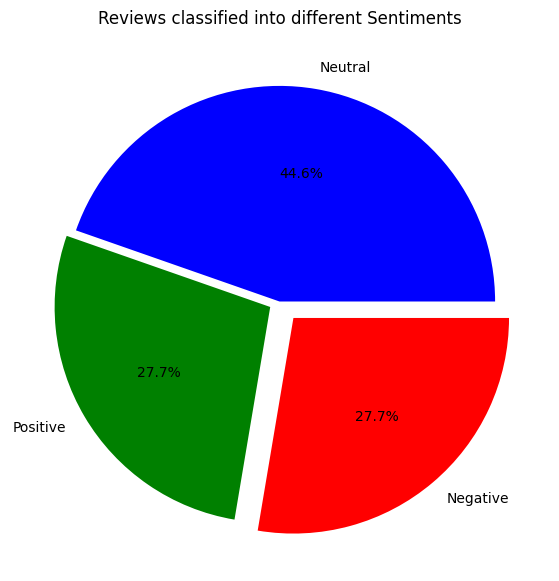

In [34]:
plt.figure(figsize=(25,7))
plt.subplot(1,3,2)
plt.title("Reviews classified into different Sentiments")
plt.pie(analysis.values, labels = analysis.index, explode = (0, 0.05, 0.1), autopct='%1.1f%%', shadow=False , colors=("blue", "green", "red"))
plt.show()

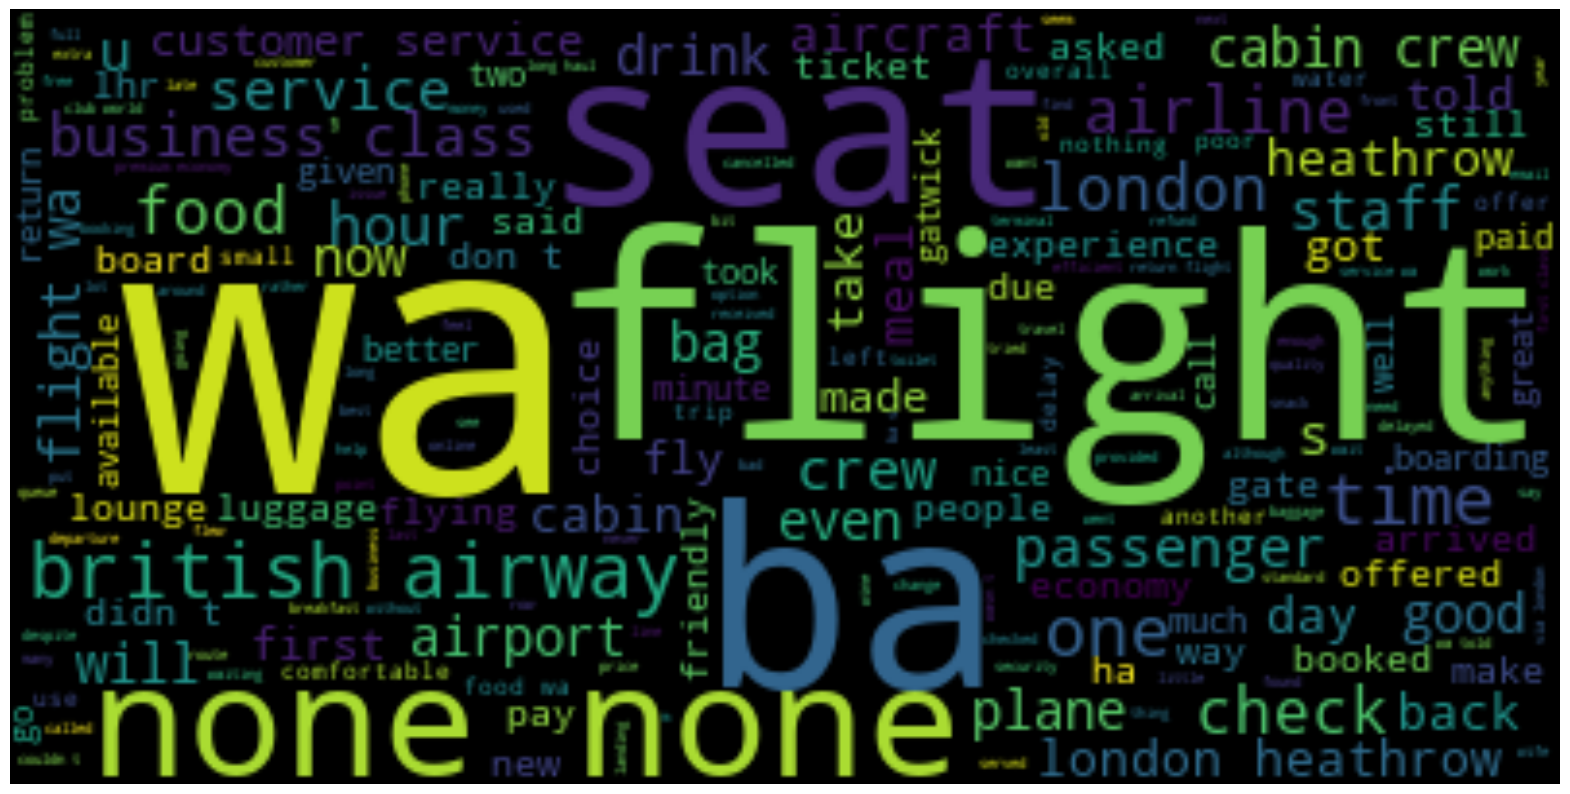

In [36]:
text = " ".join(i for i in df.reviews)   #wordcloud
wordcloud = WordCloud().generate(text)
fig = plt.figure(1, figsize=(20, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()